## 0.Importar librerias


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from wordcloud import WordCloud
import string
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Adquisición y Exploración de Datos

### 1.cargar datasets

In [4]:
# Función para cargar el dataset con nombres de columnas personalizados
def load_dataset(file_path):
    return pd.read_csv(file_path, header=None, names=['class', 'text'])

# Cargar los datasets de entrenamiento y prueba
train_df = load_dataset('train.csv')
test_df = load_dataset('test.csv')

# Mostrar las primeras filas y la información básica de los datasets
print("Dataset de entrenamiento:")
train_df.sample(8)


Dataset de entrenamiento:


,class,text
125106,2,"Great service, honest mechanic! They talked m..."
82618,2,this is one of the nicest veterinary clinics i...
451959,2,I enjoyed an absolutely delicious meal at Domi...
260582,1,They have been harassing me for month about pa...
93049,2,Some of the tastiest Persian food I've ever ha...
393123,2,My group stopped by here over 4th of July. We ...
254067,1,Blech. Had to work at U of Phoenix Stadium tod...
530525,1,The quality has definitely fallen off for this...


### 2. Análisis Exploratorio de Datos (EDA)

Definimos dos 

In [21]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def perform_eda(df, title):
    print(f"\nEDA para {title}")
    
    # Verificar las columnas disponibles
    print("Columnas disponibles:", df.columns.tolist())
    
    # Distribución de clases
    plt.figure(figsize=(10, 6))
    sns.countplot(x='class', data=df)
    plt.title(f'Distribución de Clases - {title}')
    plt.show()

    # Longitud de los textos
    df['text_length'] = df['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], bins=50)
    plt.title(f'Distribución de Longitudes de Textos - {title}')
    plt.xlabel('Longitud de Texto')
    plt.show()

    # Estadísticas básicas de la longitud de los textos
    print("\nEstadísticas de longitud de textos:")
    print(df['text_length'].describe())

    # Correlación entre longitud de texto y clase
    correlation = df['text_length'].corr(df['class'])
    print(f"\nCorrelación entre longitud de texto y clase: {correlation:.4f}")

    # Insights
    print("\nInsights:")
    print("1. Distribución de clases")
    print("2. Distribución de longitudes de textos")
    print("3. Relación entre longitud de texto y clase")



def quick_text_analysis(df, title, sample_size=1000, ngram_range=(1, 2)):
    print(f"\nAnálisis rápido de texto para {title}")
    
    # Tomar una muestra aleatoria de comentarios
    sample_texts = random.sample(df['text'].tolist(), min(sample_size, len(df)))
    
    # Crear un vectorizador para n-gramas
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    # Ajustar y transformar los textos de la muestra
    ngrams = vectorizer.fit_transform(sample_texts)
    
    # Obtener los n-gramas más comunes
    sum_words = ngrams.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Mostrar los 20 n-gramas más comunes
    top_ngrams = words_freq[:20]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[x[1] for x in top_ngrams], y=[x[0] for x in top_ngrams])
    plt.title(f'Top 20 N-gramas Más Comunes - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Frecuencia')
    plt.ylabel('N-grama')
    plt.show()
    
    # Calcular la cantidad de palabras por texto
    word_counts = [len(text.split()) for text in sample_texts]
    
    # Crear el gráfico de distribución de la cantidad de palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(word_counts, kde=True, bins=30)
    plt.title(f'Distribución de la Cantidad de Palabras por Texto - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Cantidad de Palabras')
    plt.ylabel('Frecuencia')
    plt.show()
    
    print("\nInsights:")
    print(f"1. N-gramas más comunes en una muestra de {sample_size} comentarios")
    print("2. Posibles temas o frases recurrentes en los comentarios")
    print(f"3. La longitud promedio de los textos es de {np.mean(word_counts):.2f} palabras")
    print(f"4. La mediana de la longitud de los textos es de {np.median(word_counts):.2f} palabras")
    print(f"5. El texto más corto tiene {min(word_counts)} palabras y el más largo tiene {max(word_counts)} palabras")





EDA para Dataset de Entrenamiento
Columnas disponibles: ['class', 'text', 'text_length', 'processed_text', 'encoded_class']


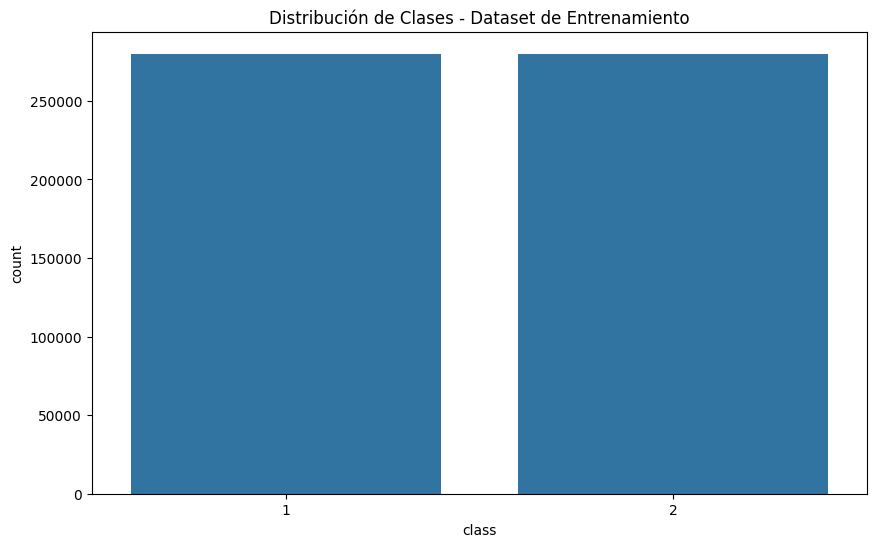

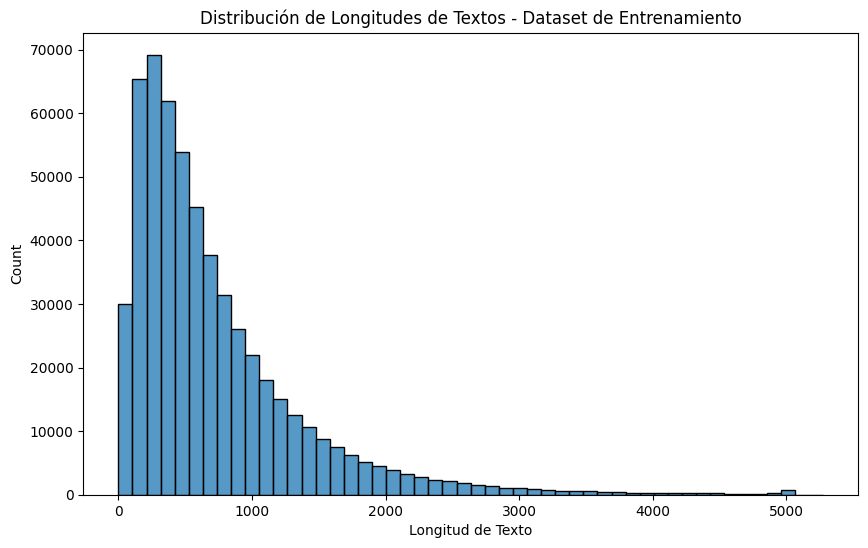


Estadísticas de longitud de textos:
count    560000.000000
mean        725.879430
std         669.001708
min           1.000000
25%         279.000000
50%         528.000000
75%         946.000000
max        5273.000000
Name: text_length, dtype: float64

Correlación entre longitud de texto y clase: -0.1407

Insights:
1. Distribución de clases
2. Distribución de longitudes de textos
3. Relación entre longitud de texto y clase


In [22]:
# Realizar EDA en los datasets de entrenamiento y prueba
perform_eda(train_df, "Dataset de Entrenamiento")


Análisis rápido de texto para Dataset de Entrenamiento


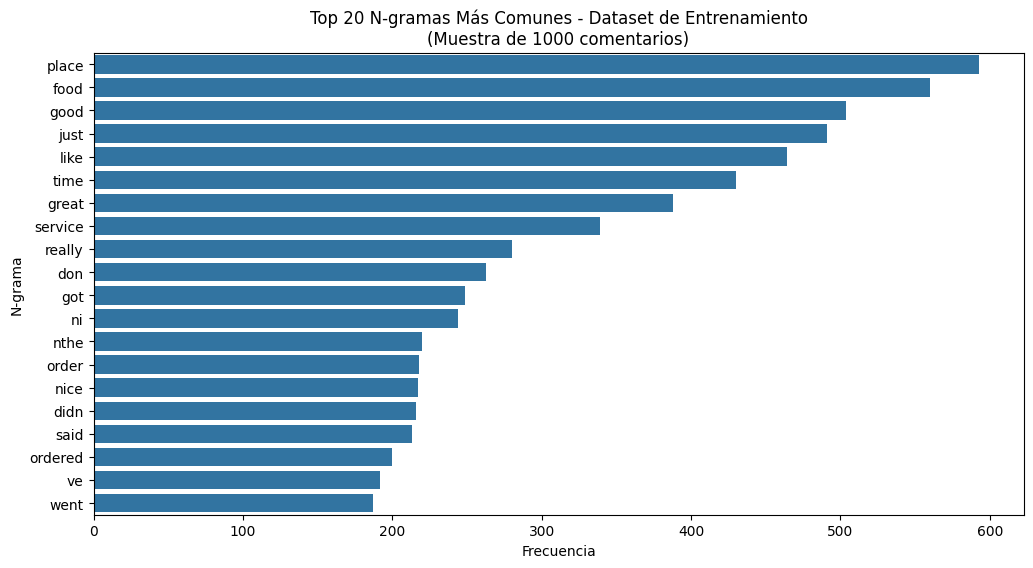

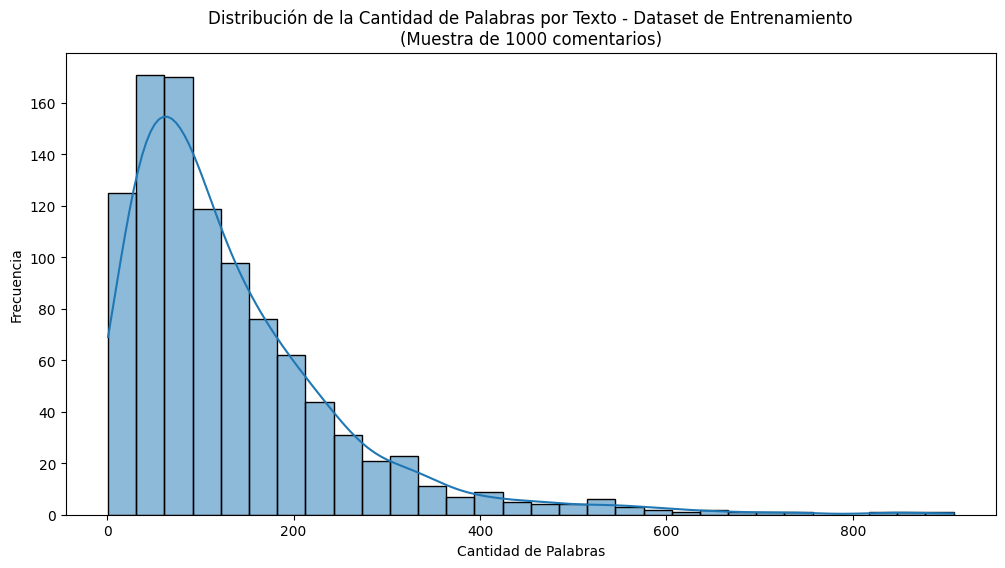


Insights:
1. N-gramas más comunes en una muestra de 1000 comentarios
2. Posibles temas o frases recurrentes en los comentarios
3. La longitud promedio de los textos es de 134.01 palabras
4. La mediana de la longitud de los textos es de 98.00 palabras
5. El texto más corto tiene 1 palabras y el más largo tiene 908 palabras


In [23]:
quick_text_analysis(train_df, "Dataset de Entrenamiento")

In [ ]:
quick_text_analysis(test_df, "Dataset de Prueba")

## 2. Preprocesamiento de datos

Definir funcion de preprocesamiento para limpiar los comentarios de signos, stopwords y llevar todo a minusculas

In [8]:
# Función de preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

In [9]:
# Aplicar preprocesamiento a los datasets
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

In [10]:
train_df.sample(8)

,class,text,text_length,processed_text
395474,2,"Delicious, great place to go if your a noodle ...",500,delici great place go noodl lover although loc...
244467,2,"For a sandwich place/cafe, this place is soooo...",545,sandwich placecaf place sooooo good flew vega ...
131359,2,A gem of Phoenix that rivals the best coffee s...,86,gem phoenix rival best coffe shop san francisc...
535188,1,I was @ the dennys on Tyvola Rd on 9/27/14 aro...,3430,denni tyvola rd around nnthe restaur full wait...
85786,1,painful review for a painful experience.\n\nI'...,1578,pain review pain experiencenn decid take gf so...
271647,2,Given the joint's small footprint I don't want...,530,given joint small footprint dont want share se...
90681,2,Since work (if you consider covering spring tr...,1892,sinc work consid cover spring train work broug...
152047,2,You haven't really been to Vegas until you've ...,537,havent realli vega youv see one show girl topl...


## 3. Feature Engineering

In [11]:
# Codificar las etiquetas
le = LabelEncoder()
train_df['encoded_class'] = le.fit_transform(train_df['class'])
test_df['encoded_class'] = le.transform(test_df['class'])

# Tokenización y padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['processed_text'])

X_train = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test = tokenizer.texts_to_sequences(test_df['processed_text'])

X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

y_train = train_df['encoded_class'].values
y_test = test_df['encoded_class'].values

print("Forma de los datos de entrenamiento:", X_train_pad.shape)
print("Forma de los datos de prueba:", X_test_pad.shape)

Forma de los datos de entrenamiento: (560000, 200)
Forma de los datos de prueba: (38000, 200)


## 4. Desarrollo del modelo inicial

In [1]:
# Define the model
model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=4, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'Sequential' is not defined

In [20]:
# Get the original text, real class, and predicted class for the last 10 examples
last_10_indices = test_df.index[-10:]
original_texts = test_df.loc[last_10_indices, 'text'].tolist()
real_classes = le.inverse_transform(y_test[-10:])
predicted_classes = le.inverse_transform(y_pred_classes[-10:])

# Print the results
print("\nLast 10 examples:")
print("=" * 80)
for i, (text, real, pred) in enumerate(zip(original_texts, real_classes, predicted_classes), 1):
    print(f"Example {i}:")
    print(f"Original text: {text[:100]}...")  # Truncate long texts
    print(f"Real class: {real}")
    print(f"Predicted class: {pred}")
    print("-" * 80)


Last 10 examples:
Example 1:
Original text: This was my first Yelp Elite event and my first chance to meet Risa, as well as some other great peo...
Real class: 2
Predicted class: 2
--------------------------------------------------------------------------------
Example 2:
Original text: I'm in love with this adorable little shop! It's PERFECT! Something for everyone, you'll never leave...
Real class: 2
Predicted class: 2
--------------------------------------------------------------------------------
Example 3:
Original text: 'Twas the week before Christmas and all through the QC, Yelpers were celebrating - more American Mul...
Real class: 2
Predicted class: 2
--------------------------------------------------------------------------------
Example 4:
Original text: This place was just okay for me. It was nothing spectacular and there weren't fireworks on my tongue...
Real class: 1
Predicted class: 1
--------------------------------------------------------------------------------
Examp

## 5.Mejora del modelo

In [15]:
# Define the improved model
improved_model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the improved model
improved_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# Train the improved model
improved_history = improved_model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the improved model
improved_loss, improved_accuracy = improved_model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Improved model test accuracy: {improved_accuracy:.4f}')


Epoch 1/4
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 359s 102ms/step - accuracy: 0.8522 - loss: 0.3221 - val_accuracy: 0.9375 - val_loss: 0.1572 - learning_rate: 0.0010
Epoch 2/4
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 342s 98ms/step - accuracy: 0.9326 - loss: 0.1748 - val_accuracy: 0.9424 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 3/4
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 346s 99ms/step - accuracy: 0.9421 - loss: 0.1516 - val_accuracy: 0.9437 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 4/4
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 352s 101ms/step - accuracy: 0.9486 - loss: 0.1351 - val_accuracy: 0.9439 - val_loss: 0.1459 - learning_rate: 0.0010
Improved model test accuracy: 0.9383
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step


TypeError: object of type 'numpy.int64' has no len()

In [19]:
y_pred

array([[7.83285856e-01, 2.16708809e-01, 5.33546336e-06],
       [9.97858346e-01, 2.14168034e-03, 4.99444747e-21],
       [6.55090362e-02, 9.34490979e-01, 1.42266199e-10],
       ...,
       [9.97584462e-01, 2.41554645e-03, 3.29168641e-20],
       [9.99803841e-01, 1.96215406e-04, 6.65457811e-28],
       [9.99040186e-01, 9.59811383e-04, 1.32253895e-23]], dtype=float32)

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step
Clases únicas en y_test: [0 1]
              precision    recall  f1-score   support

     Class_0       0.94      0.93      0.94     19000
     Class_1       0.93      0.94      0.94     19000

    accuracy                           0.94     38000
   macro avg       0.94      0.94      0.94     38000
weighted avg       0.94      0.94      0.94     38000



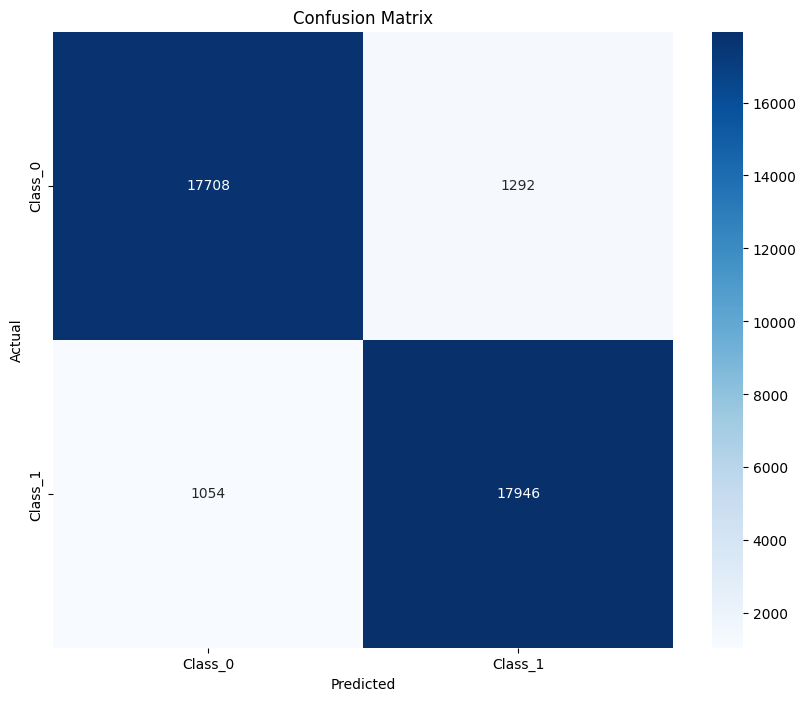

In [16]:
# Genera predicciones
y_pred = improved_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verifica las clases únicas en y_test
unique_classes = np.unique(y_test)
print("Clases únicas en y_test:", unique_classes)

# Crea una lista de nombres de clases
class_names = [f"Class_{i}" for i in range(len(unique_classes))]

# Imprime el informe de clasificación
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Plot de la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Resumen y conclusiones

In [ ]:
print("Conclusiones:")
print("1. Logramos desarrollar un modelo de analisis de sentimiento para el feedback de los consumidores usando técnicas de deeplearning.")
print(f"2. El accuracy alcanzado por el modelo mejora es de {improved_accuracy:.2f}, el cual es superador del de modelo base que fue {accuracy:.2f}.")
print("3.El modelo es capaz de recibir texto de nuevos comentarios y clasificarlos entre positivos, neutros y negativods")
print("4. La matriz de confusion nos permite ver que el modelo funciona bien en todas las categorias, con oportunidad de mejoras para distinguir entre feedbacks positivos y neutrales")
print("\nFortalezas:")
print("- El modelo puede procesar y analizar grande volumenes de data de forma eficiente.")
print("- Es capaz de capturas patrones complejos en el lenguaje que modelos mas simples no pueden.")
print("\nDebilidades:")
print("- El modelo puede tener problemas para detectar el sarcasmo o sentimientos dependientes de contexto completo del texto.")
print("- Requiere volúmenes grande de data para el entrenamiento.")
print("\nPotenciales mejoras:")
print("1. Experiment with more advanced architectures like transformers (e.g., BERT).")
print("2. Incorporate additional features such as user history or business attributes.")
print("3. Implement techniques to handle class imbalance if present in the dataset.")
print("4. Explore transfer learning from pre-trained language models.")